In [1]:
# Dependencies
import tweepy
import json
import pandas as pd
import matplotlib.pyplot as plt
import config
import numpy as np
import time
%matplotlib inline

In [2]:
# Setup Tweepy API Authentication
# My api keys are stored in a config file, instead of separately

auth = tweepy.OAuthHandler(config.api_key, config.api_secret)
auth.set_access_token(config.access_token, config.token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [3]:
# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [4]:
#speficy news outlets
#After getting the scatter plot, there weren't any obviously negative scores, so I added Russia Today

target_user = ['@TheFakeCNN','@NYTOnit','@TheOnion','@BreakingNews',"@GomerBlog"]

In [5]:
#set up dictionary of lists
tweet_data = {'Source':[],
               'Text':[],
               'Date':[], 
               'Compound':[],
               'Negative':[], 
               'Neutral':[],
               'Positive':[]}

#gather 100 tweets from each news outlet in list
for x in range(5):
    time.sleep(0.5)
    
    
    #do API calls
    for i in target_user:
        user_tweets = api.user_timeline(i,page=x)
        
        #Append tweet data
        for tweet in user_tweets:
            #Appending basic information required
            tweet_data['Source'].append(tweet['user']['name'])
            tweet_data['Text'].append(tweet['text'])
            tweet_data['Date'].append(tweet['created_at'])
        
            
            
            #Append sentiment score 
            score = analyzer.polarity_scores(tweet["text"])
            tweet_data['Compound'].append(score['compound'])
            tweet_data['Negative'].append(score['neg'])
            tweet_data['Neutral'].append(score['neu'])
            tweet_data['Positive'].append(score['pos'])
            

In [6]:
#Dataframe of sentiment
sentiment_df = pd.DataFrame(tweet_data)

In [7]:
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])

In [8]:
#select order of display for df
sentiment_df = sentiment_df[['Source',
             'Date',
             'Text',
             'Positive',
             'Neutral',
             'Negative',
             'Compound']]

In [9]:
len(sentiment_df)

499

In [10]:
#Create CSV from DF
sentiment_df.to_csv("fake_sentiment.csv",sep=',')

In [11]:
#separate sentiments into different news outlets
ONN = sentiment_df[sentiment_df['Source']=='The Onion']
BRN = sentiment_df[sentiment_df['Source']=='Breaking News']
CNN = sentiment_df[sentiment_df['Source']=='The Fake CNN']
NYT = sentiment_df[sentiment_df['Source']=='The Times Is On It']
GOM = sentiment_df[sentiment_df['Source']=='GomerBlog']

In [12]:
#There are 100 tweets per outlet, so choosing one outlet to set the axis
number_tweets = np.arange(-len(sentiment_df[sentiment_df["Source"] == 'GOM']), 0, 1)

In [13]:
#Calculate the mean of the compound scores in order to have one number to use for the bar plot
#Note to self: 'Compound' is the average of all the scores PER TWEET. 
#Need mean to get an overall number for the total tweets, all together. It's an average of a ton of other averages.

ONN_mean = ONN['Compound'].mean()
BRN_mean = BRN['Compound'].mean()
CNN_mean = CNN['Compound'].mean()
NYT_mean = NYT['Compound'].mean()
GOM_mean = GOM['Compound'].mean()

In [14]:
#axis setup
compound_list = [ONN_mean, BRN_mean, CNN_mean, NYT_mean, GOM_mean]
x_axis = np.arange(len(compound_list))

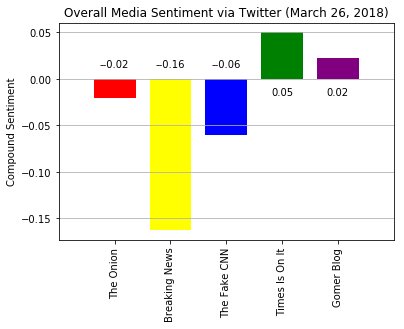

In [18]:
#bar graph of percent of overall sentiment
fig, ax = plt.subplots()
ind = x_axis

#Set graph parameters
ax.set_xticks(ind)
ax.set_title('Overall Media Sentiment via Twitter (March 26, 2018)')
ax.set_ylabel('Compound Sentiment')
ax.set_xticklabels(('The Onion', 'Breaking News', 'The Fake CNN', 'Times Is On It', 'Gomer Blog'), rotation='vertical')
ax.set_xlim(-1, 5)

#ax.set_ylim(-1.25,1.25) - This did not work. Graph was crazy. No average scores reached the upper or lower limits.
#Used autoscaley instead. Leaving this for my future reference.

ax.set_autoscaley_on(True)

width = 0.75
#height = 1
ax.yaxis.grid(True, which='major')

#Create each bar. ind = each thing on the compound_list & is separated by news outlet
#Using same colors as scatter plot

ONN_bar = ax.bar(ind[0],ONN_mean,width, color = 'red')
BRN_bar = ax.bar(ind[1],BRN_mean,width, color = 'yellow')
CNN_bar = ax.bar(ind[2],CNN_mean,width, color = 'blue')
NYT_bar = ax.bar(ind[3],NYT_mean,width, color = 'green')
GOM_bar = ax.bar(ind[4],GOM_mean,width, color = 'purple')

# Label with polarity.
#Script recycled from previous homework with some values changed.
#Must view the graph prior to deciding which gets the pos and neg labels

def label_pos(rect_pos):
    for rect in rect_pos:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2.0, -0.02,
         '%0.2f' % float(height),
           ha='center', va='bottom', color='black')

def label_neg(rect_neg):
    for rect in rect_neg:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2.0, 0.01,
         '-%0.2f' % float(height),
           ha='center', va='bottom', color='black')

#After viewing graph, each polarity score is labeled in the correct position, depending on if it was pos or neg

#Positive scores
label_pos(NYT_bar)
label_pos(GOM_bar)

#Negative scores
label_neg(ONN_bar)
label_neg(CNN_bar)
label_neg(BRN_bar)

#Save plot as png
plt.savefig('fake_bar_plot_overall_sentiment.png')